In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from itertools import product

warnings.filterwarnings("ignore")


In [16]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)
        df_all = df_all.fillna(0)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)


In [17]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("standard", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("standard", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: standard
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: standard
Train final: (125973, 64)
Test final : (22544, 64)


# 5. MLP Classifier


## Treinamento e Avaliação Inicial

Treinamento do MLP com os hiperparâmetros principais do artigo e avaliação inicial no conjunto de validação.

In [4]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

mlp = MLPClassifier(
    hidden_layer_sizes=(100,), # default, não especificado no artigo
    solver='sgd',               # necessário para ativar momentum
    learning_rate_init=0.3,     # conforme artigo
    momentum=0.2,               # conforme artigo
    early_stopping=True,        # permite parada com base na validação
    n_iter_no_change=20,        # conforme artigo (validation threshold)
    max_iter=200,               # comum em benchmarks
    random_state=1,
    verbose=True
)

mlp.fit(X_train, y_train_enc) 
y_pred = mlp.predict(X_val)

print("Acurácia:", accuracy_score(y_val_enc, y_pred))
print(classification_report(y_val_enc, y_pred, digits=4))


Iteration 1, loss = 0.08351090
Validation score: 0.987994
Iteration 2, loss = 0.03920709
Validation score: 0.991665
Iteration 3, loss = 0.03310709
Validation score: 0.991863
Iteration 4, loss = 0.02926380
Validation score: 0.993253
Iteration 5, loss = 0.02637786
Validation score: 0.990574
Iteration 6, loss = 0.02538870
Validation score: 0.991566
Iteration 7, loss = 0.02332825
Validation score: 0.991169
Iteration 8, loss = 0.02212600
Validation score: 0.992756
Iteration 9, loss = 0.02101180
Validation score: 0.992360
Iteration 10, loss = 0.01989922
Validation score: 0.993947
Iteration 11, loss = 0.01923259
Validation score: 0.993749
Iteration 12, loss = 0.01900963
Validation score: 0.993848
Iteration 13, loss = 0.01844330
Validation score: 0.994642
Iteration 14, loss = 0.01809316
Validation score: 0.994840
Iteration 15, loss = 0.01716986
Validation score: 0.993153
Iteration 16, loss = 0.01689849
Validation score: 0.993352
Iteration 17, loss = 0.01665871
Validation score: 0.992756
Iterat

### Busca de Hiperparâmetros 

In [5]:
# Codificação
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Grid enxuto baseado no artigo
activation_list = ['relu', 'tanh']
hidden_layer_sizes_list = [(100,), (100, 50)]
alpha_list = [0.0001, 0.001]
batch_size_list = [64, 128]

# Parâmetros fixos do artigo
learning_rate_init = 0.3
momentum = 0.2
n_iter_no_change = 20
max_iter = 200
solver = 'sgd'
random_state = 1

# Executar combinações
results = []
for activation, hls, alpha, batch_size in product(activation_list, hidden_layer_sizes_list, alpha_list, batch_size_list):
    clf = MLPClassifier(
        activation=activation,
        hidden_layer_sizes=hls,
        alpha=alpha,
        batch_size=batch_size,
        learning_rate_init=learning_rate_init,
        momentum=momentum,
        n_iter_no_change=n_iter_no_change,
        max_iter=max_iter,
        solver=solver,
        early_stopping=True,
        random_state=random_state,
        verbose=True
    )
    clf.fit(X_train, y_train_enc)
    y_pred = clf.predict(X_val)
    
    acc = accuracy_score(y_val_enc, y_pred)
    f1 = f1_score(y_val_enc, y_pred, average='macro')

    results.append({
        'activation': activation,
        'hidden_layer_sizes': hls,
        'alpha': alpha,
        'batch_size': batch_size,
        'accuracy': acc,
        'f1_macro': f1
    })

# Exibir resultados
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
print(df_sorted)

   activation hidden_layer_sizes   alpha  batch_size  accuracy  f1_macro
0        tanh             (100,)  0.0001          64  0.995713  0.918910
1        tanh             (100,)  0.0001         128  0.995475  0.916376
2        tanh          (100, 50)  0.0010          64  0.996229  0.910666
3        tanh             (100,)  0.0010         128  0.996269  0.909353
4        relu          (100, 50)  0.0001         128  0.996547  0.897312
5        relu          (100, 50)  0.0001          64  0.996150  0.895690
6        relu          (100, 50)  0.0010         128  0.996309  0.895597
7        tanh             (100,)  0.0010          64  0.994959  0.883935
8        relu             (100,)  0.0001         128  0.996348  0.882912
9        relu             (100,)  0.0001          64  0.995872  0.881499
10       relu             (100,)  0.0010         128  0.996309  0.876666
11       tanh          (100, 50)  0.0001         128  0.996150  0.867391
12       tanh          (100, 50)  0.0010         12

## Melhor Modelo

In [10]:
best_clf = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(100,),
    alpha=0.0001,
    batch_size=64,
    learning_rate_init=0.3,
    momentum=0.2,
    n_iter_no_change=20,
    max_iter=200,
    solver='sgd',
    early_stopping=True,  # ← necessário
    random_state=1,
    verbose=False
)


# Treinar no conjunto completo de treino
best_clf.fit(X_train, y_train_enc)

# Avaliar no conjunto de validação
y_pred = best_clf.predict(X_val)

cm = confusion_matrix(y_val_enc, y_pred)
tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (None, None, None, None)  # Só para binário

# Scores principais
accuracy = accuracy_score(y_val_enc, y_pred)
precision = precision_score(y_val_enc, y_pred, average='macro')
recall = recall_score(y_val_enc, y_pred, average='macro')
f1 = f1_score(y_val_enc, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred))

# AUC (só se for binário)
try:
    y_prob = best_clf.predict_proba(X_val)
    auc = roc_auc_score(y_val_enc, y_prob, multi_class='ovr')
except:
    auc = None

# Exibição
print("\n=== Métricas de Desempenho ===")
print(f"{'Acurácia:':<25} {accuracy:.4f}")
print(f"{'F1-score (macro):':<25} {f1:.4f}")
print(f"{'Precisão (macro):':<25} {precision:.4f}")
print(f"{'Recall (macro / TPR médio):':<25} {recall:.4f}")
if auc is not None:
    print(f"{'AUC-ROC:':<25} {auc:.4f}")
print(f"{'RMSE:':<25} {rmse:.4f}")
if tn is not None:
    print(f"{'Taxa de falso positivo (FPR):':<25} {fp / (fp + tn):.4f}")
    print(f"{'Taxa de falso negativo (FNR):':<25} {fn / (fn + tp):.4f}")
print("==============================\n")



=== Métricas de Desempenho ===
Acurácia:                 0.9957
F1-score (macro):         0.9189
Precisão (macro):         0.9257
Recall (macro / TPR médio): 0.9129
AUC-ROC:                  0.9982
RMSE:                     0.1758



### Avaliação do Melhor Modelo

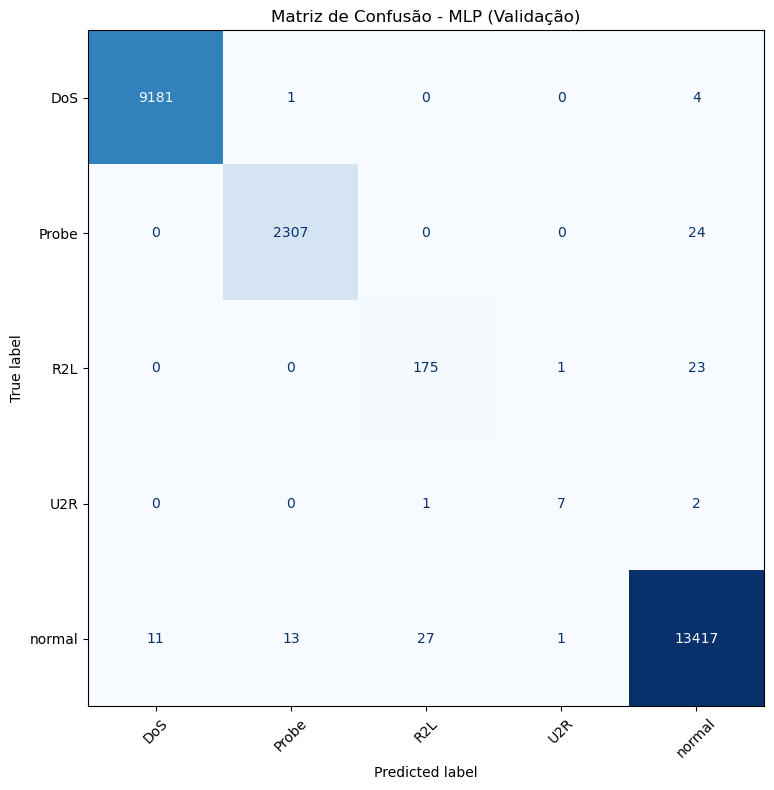

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9961    0.9961    0.9961     13469
      attack     0.9956    0.9955    0.9955     11726

    accuracy                         0.9958     25195
   macro avg     0.9958    0.9958    0.9958     25195
weighted avg     0.9958    0.9958    0.9958     25195



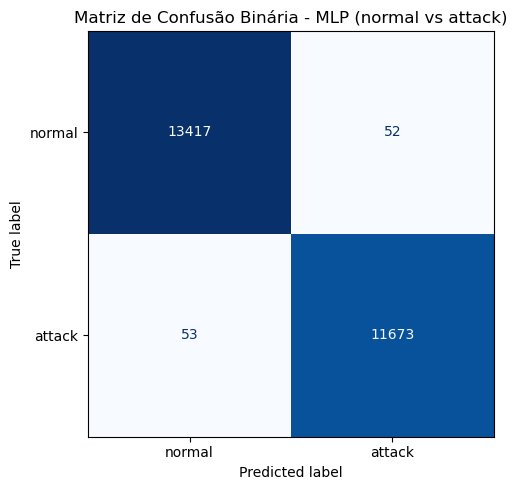

In [11]:
y_val_labels = le.inverse_transform(y_val_enc)
y_pred_labels = le.inverse_transform(y_pred)

# ============================
# Matriz de Confusão Multiclasse
# ============================
labels = sorted(pd.Series(y_val_labels).unique())
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - MLP (Validação)")
plt.grid(False)
plt.tight_layout()
plt.show()

# ============================
# Matriz de Confusão Binária (normal vs ataque)
# ============================
# Gera rótulos binários: 0 = normal, 1 = ataque
y_val_bin = pd.Series(y_val_labels).apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred_labels).apply(lambda x: 0 if x == "normal" else 1)

print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - MLP (normal vs attack)")
plt.grid(False)
plt.tight_layout()
plt.show()

## Avaliação Final no Conjunto de Teste Real (KDDTest+)

O modelo MLP selecionado é treinado com todos os dados de treino e avaliado no conjunto de teste real (`KDDTest+`). 

In [19]:

# Codificar os rótulos
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_final)
y_test_enc = le.transform(y_test_final)

# Definir o modelo com a mesma configuração validada anteriormente
best_clf = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(100,),
    alpha=0.0001,
    batch_size=64,
    learning_rate_init=0.3,
    momentum=0.2,
    n_iter_no_change=20,
    max_iter=200,
    solver='sgd',
    early_stopping=True,
    random_state=1,
    verbose=True
)

# Treinar no KDDTrain+
best_clf.fit(X_train_final, y_train_enc)

# Predição no KDDTest+
y_pred = best_clf.predict(X_test_final)
y_proba = best_clf.predict_proba(X_test_final)

# Métricas principais
accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='macro')
recall = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred))

# Matriz de confusão e estatísticas derivadas
cm = confusion_matrix(y_test_enc, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))

# AUC-ROC
try:
    auc = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
except:
    auc = None

# Exibição final
print("\n==== Avaliação Final - MLP (KDDTrain+ vs KDDTest+) ====")
print(f"{'Acurácia:':<30} {accuracy:.4f}")
print(f"{'F1-score (macro):':<30} {f1:.4f}")
print(f"{'Precisão (macro):':<30} {precision:.4f}")
print(f"{'Recall (macro / TPR):':<30} {recall:.4f}")
print(f"{'AUC-ROC:':<30} {auc:.4f}" if auc is not None else "AUC-ROC:                   Não aplicável")
print(f"{'RMSE:':<30} {rmse:.4f}")
print(f"{'FPR (média):':<30} {fpr:.4f}")
print(f"{'FNR (média):':<30} {fnr:.4f}")
print("==============================================")


Iteration 1, loss = 0.05226667
Validation score: 0.985871
Iteration 2, loss = 0.02898029
Validation score: 0.990633
Iteration 3, loss = 0.02452205
Validation score: 0.990951
Iteration 4, loss = 0.02201884
Validation score: 0.994126
Iteration 5, loss = 0.02007202
Validation score: 0.992300
Iteration 6, loss = 0.01896055
Validation score: 0.993491
Iteration 7, loss = 0.01758515
Validation score: 0.994205
Iteration 8, loss = 0.01675127
Validation score: 0.994840
Iteration 9, loss = 0.01578702
Validation score: 0.995793
Iteration 10, loss = 0.01531842
Validation score: 0.994126
Iteration 11, loss = 0.01446569
Validation score: 0.995952
Iteration 12, loss = 0.01429121
Validation score: 0.992856
Iteration 13, loss = 0.01358616
Validation score: 0.995714
Iteration 14, loss = 0.01299777
Validation score: 0.995634
Iteration 15, loss = 0.01250702
Validation score: 0.995714
Iteration 16, loss = 0.01219581
Validation score: 0.995714
Iteration 17, loss = 0.01178314
Validation score: 0.996110
Iterat

### Relatório

Relatório de precisão, recall e F1-score para cada categoria no conjunto de teste real.

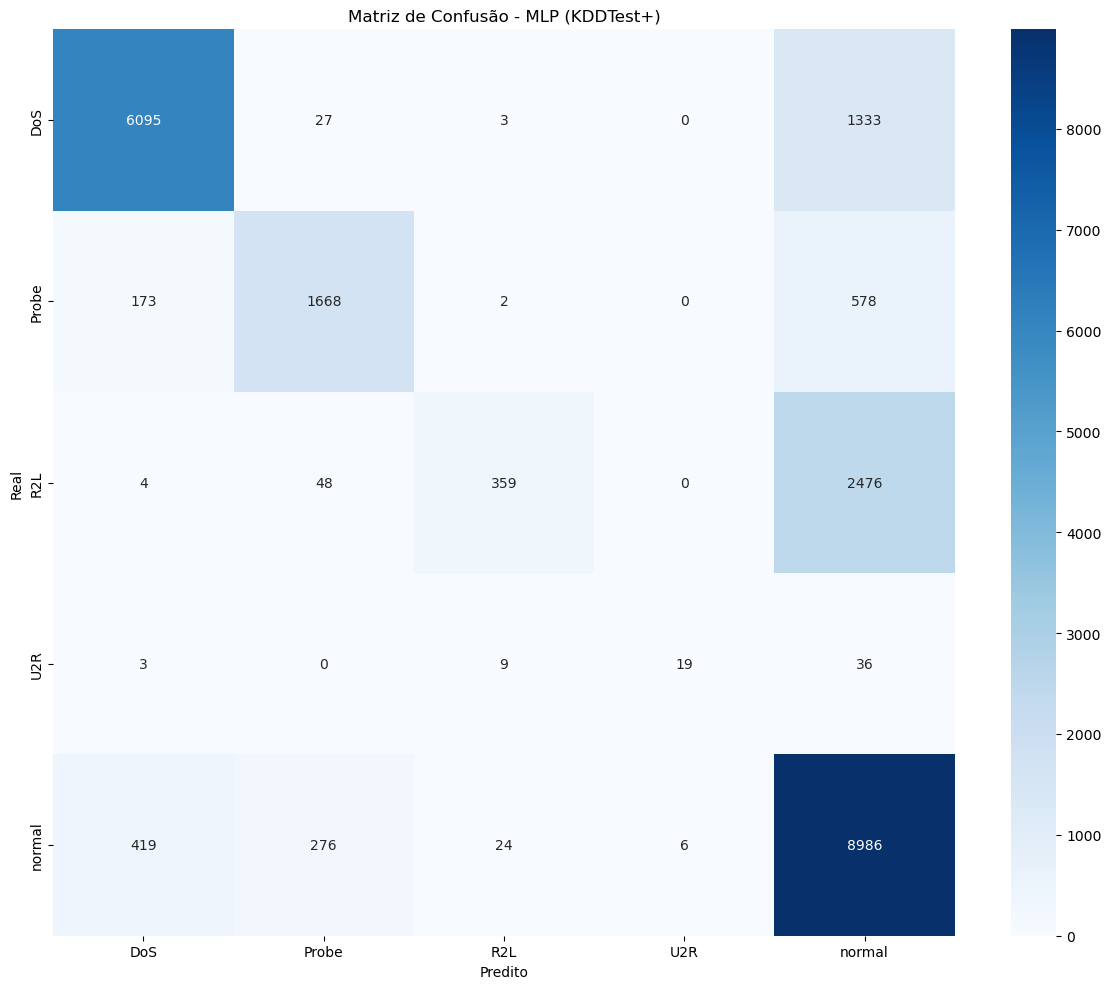

In [20]:
# Matriz de confusão visual
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - MLP (KDDTest+)')
plt.tight_layout()
plt.show()



In [22]:
y_test_labels = le.inverse_transform(y_test_enc)
y_pred_labels = le.inverse_transform(y_pred)

# Gerar o relatório detalhado
report_dict = classification_report(
    y_test_labels,
    y_pred_labels,
    output_dict=True,
    digits=4
)

# Transformar em DataFrame e exibir
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

              precision    recall  f1-score       support
DoS            0.910517  0.817243  0.861362   7458.000000
Probe          0.826152  0.688971  0.751351   2421.000000
R2L            0.904282  0.124351  0.218636   2887.000000
U2R            0.760000  0.283582  0.413043     67.000000
normal         0.670147  0.925342  0.777336   9711.000000
accuracy       0.759714  0.759714  0.759714      0.759714
macro avg      0.814219  0.567898  0.604346  22544.000000
weighted avg   0.796670  0.759714  0.729713  22544.000000


              precision    recall  f1-score       support
normal         0.670147  0.925342  0.777336   9711.000000
attack         0.920635  0.655342  0.765659  12833.000000
accuracy       0.771647  0.771647  0.771647      0.771647
macro avg      0.795391  0.790342  0.771497  22544.000000
weighted avg   0.812735  0.771647  0.770689  22544.000000


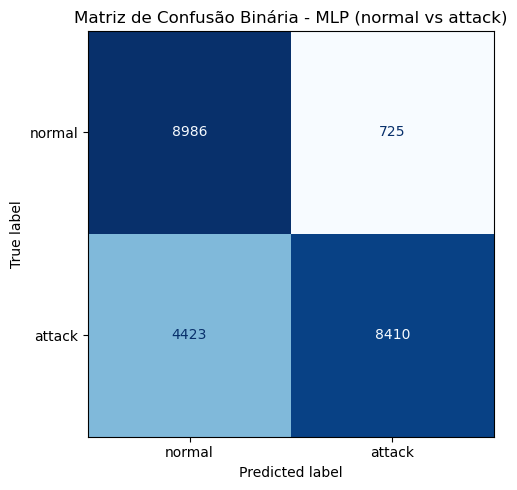

In [23]:
y_test_bin = pd.Series(y_test_labels).apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred_labels).apply(lambda x: 0 if x == "normal" else 1)

# Relatório
report_bin = classification_report(
    y_test_bin,
    y_pred_bin,
    target_names=["normal", "attack"],
    digits=4,
    output_dict=True
)

report_bin_df = pd.DataFrame(report_bin).transpose()
print(report_bin_df)

# Matriz de confusão binária
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - MLP (normal vs attack)")
plt.grid(False)
plt.tight_layout()
plt.show()